In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import datetime

from helper import make_alphas_state_matrix_with_day_step
from helper import instrument_return, merge_zeros
from helper import AlphaStats, calc_alphas_corr, std
from helper import normalize, neutralize, neutralize_with_dropout

import manipulate_alpha as mpa

from test import test1, test2, test3
from typing import NamedTuple

SLICE_INDEX = 2436

In [4]:
def decay (alpha_matrix, n): # decrease turnover
    
    factors = (np.arange(1, n + 2)) / (n+1)

    _new_alpha_states = alpha_matrix.copy()

    for idx in range(n+1, len(alpha_matrix)):
        _alpha = alpha_matrix[idx-n-1:idx] * np.array([factors]).T
        if not np.array_equal(_alpha, np.zeros_like(_alpha)):
            _new_alpha_states[idx] = _alpha.sum(axis=0)
    
    # return _alpha
    return _new_alpha_states 

In [5]:
def ts_correlation(x, y):
    corr_vec = np.zeros(x.shape[1])

    for idx, (_x, _y) in enumerate(zip(x, y)):
        corr_vec[idx] = calc_alphas_corr(_x, _y)

    return corr_vec

In [6]:
class Alphas_Data(NamedTuple):
    name: str
    cumpnl: np.array

In [179]:
def check_alpha_correlations(alphas, cumpnl_vec):
    for alpha in alphas:
        print(f'{alpha.name}:\t{calc_alphas_corr(alpha.cumpnl, cumpnl_vec)}')

In [7]:
alphas = []

# Creat Dataset

In [8]:
dataset_dir = './USA_2010-2014_HLOCV'
os.listdir(dataset_dir)

['Open.csv', 'High.csv', 'Close.csv', 'Low.csv', 'Volume.csv']

In [9]:
open_df = pd.read_csv(dataset_dir + '/Open.csv')
high_df = pd.read_csv(dataset_dir + '/High.csv')
close_df = pd.read_csv(dataset_dir + '/Close.csv')
low_df = pd.read_csv(dataset_dir + '/Low.csv')
volume_df = pd.read_csv(dataset_dir + '/Volume.csv')

## Mean-reversion alpha

$-ln\frac{open(d)}{close(d-1)}$

In [10]:
day_step = 5

In [11]:
def make_mean_reversion_alpha(close_df, open_df, day_step):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    alpha = -np.log(open[day_step:] / close[:-day_step])
    return np.concatenate((np.zeros((day_step, alpha.shape[1])), alpha))

In [12]:
mean_reversion_alpha = make_mean_reversion_alpha(close_df, open_df, day_step)

# mean_reversion_alpha, zeros_outliers = mpa.CutOutliers(mean_reversion_alpha, 1)
# mean_reversion_alpha, zeros_middles = mpa.CutMiddle(mean_reversion_alpha, 10)

# mean_reversion_alpha = mpa.truncate_alpha(mean_reversion_alpha, 0.05)
# mean_reversion_alpha = decay(mean_reversion_alpha, 10)

# mean_reversion_alpha = mpa.crop(mean_reversion_alpha, 0.1)
# zeros_merged = merge_zeros(zeros_outliers, zeros_middles) 

# mean_reversion_alpha = neutralize_with_dropout(mean_reversion_alpha, zeros_outliers)
# mean_reversion_alpha = neutralize_with_dropout(mean_reversion_alpha,zeros_middles)

mean_reversion_alpha = neutralize(mean_reversion_alpha)
mean_reversion_alpha = normalize(mean_reversion_alpha)

In [13]:
test1(mean_reversion_alpha)
test2(mean_reversion_alpha[day_step:])

Neutrality test passed
Normality test passed


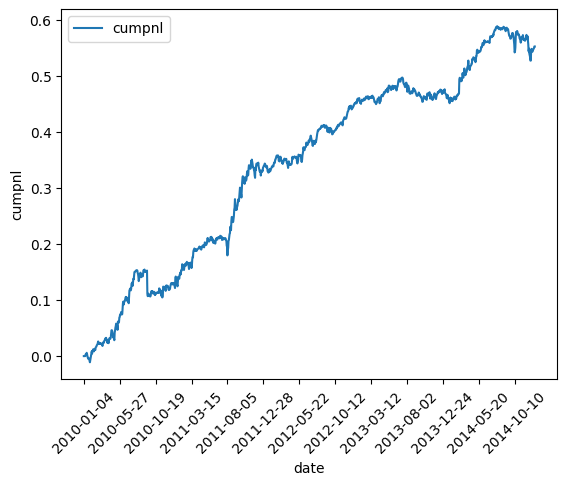

[0.13013280477519074, 0.3397833709379966, 0.4478529330706973, 0.4751585233529981, 0.5534736520708535]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.826766,0.703284,0.049820,0.130133
1,2011,2.661697,0.715459,0.035109,0.339783
2,2012,2.382048,0.712227,0.022373,0.447853
3,2013,0.601442,0.706987,0.043365,0.475159
4,2014,1.197006,0.704996,0.061401,0.553474


In [14]:
mean_rev_alpha_data, mean_rev_alpha_cumpnl = AlphaStats(mean_reversion_alpha, close_df)
mean_rev_alpha_data.head()

In [15]:
test3(mean_rev_alpha_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [16]:
alphas.append(Alphas_Data('mean_reverse', mean_rev_alpha_cumpnl))

## Momentum alpha

$ln\frac{close(d-1)}{open(d-1)}$

In [17]:
def make_momentum_alpha(close_df, open_df, day_step):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    alpha = -np.log(close[day_step:] / open[day_step:])
    return np.concatenate((np.zeros((day_step, alpha.shape[1])), alpha))

In [18]:
day_step = 1

momentum_alpha = make_momentum_alpha(close_df, open_df, day_step)
# momentum_alpha, zeros_outliers = mpa.CutOutliers(momentum_alpha, 10)
# momentum_alpha = mpa.truncate_alpha(momentum_alpha, 0.01)
momentum_alpha = decay(momentum_alpha, 10)

# mean_reversion_alpha = neutralize_with_dropout(mean_reversion_alpha, zeros_outliers)
momentum_alpha = neutralize(momentum_alpha)
momentum_alpha = normalize(momentum_alpha)

In [19]:
test1(momentum_alpha)
test2(momentum_alpha[day_step:])

Neutrality test passed
Normality test passed


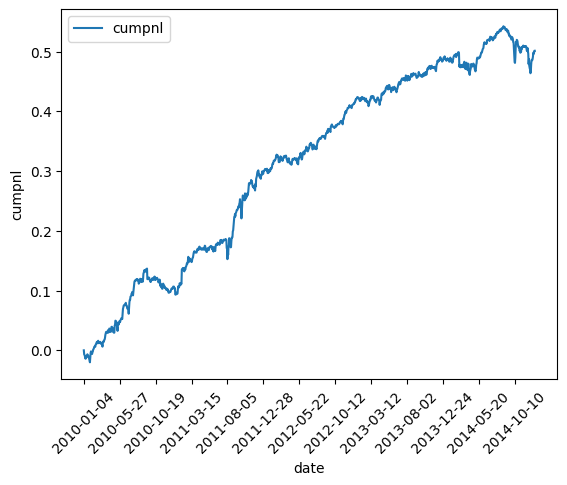

[0.10661293792031856, 0.3002020191697033, 0.41216837396106537, 0.4888151010074261, 0.5013727770371479]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,2.039785,0.525302,0.040283,0.106613
1,2011,2.744481,0.485311,0.033744,0.300202
2,2012,2.879972,0.477292,0.016937,0.412168
3,2013,1.992797,0.479547,0.015440,0.488815
4,2014,0.199084,0.487745,0.078618,0.501373


In [20]:
momentum_alpha_data, momentum_alpha_cumpnl = AlphaStats(momentum_alpha, close_df)
momentum_alpha_data.head()

In [21]:
test3(momentum_alpha_data)

Sharpe test passed
Turnover test passed
Cumpnl test passed
passed 3 out of 3 tests


In [180]:
check_alpha_correlations(alphas, momentum_alpha_cumpnl)

mean_reverse:	0.9926339585133639


## Alpha 1

**(rank(Ts_ArgMax(SignedPower(((returns < 0) ? stddev(returns, 20) : close), 2.), 5)) - 0.5)**

In [23]:
def make_alpha_1(close_df, day_step):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    return_matrix = instrument_return(close_df)

    alpha = np.zeros((close.shape))

    for i in range(day_step, len(close)):
        alpha[i] += np.where(return_matrix[i] > 0, std(return_matrix[i-day_step:i]), close[i])**2.

    sub_alpha = np.zeros((close.shape))

    for i in range(5, len(alpha)):
        # print(mpa.rank(np.argmax(alpha[i-5:i], axis=0)))
        sub_alpha[i] += np.argmax(alpha[i-5:i], axis=0)# - 0.5

    for i in range(day_step, len(close)):
        alpha[i] = mpa.rank(sub_alpha[i]) - 0.5

    return -alpha

In [24]:
alpha_1 = make_alpha_1(close_df, 20)
# alpha_1, zeros = mpa.CutMiddle(alpha_1, 5)
alpha_1 = mpa.truncate_alpha(alpha_1, 0.03)

In [25]:
# alpha_1 = neutralize_with_dropout(alpha_1, zeros)
alpha_1 = neutralize(alpha_1)
alpha_1 = normalize(alpha_1)

In [26]:
test1(alpha_1)
test2(alpha_1[20:])

Neutrality test passed
Normality test passed


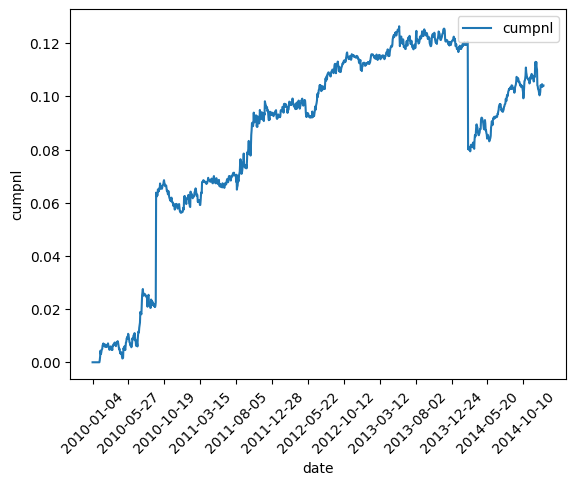

[0.05659399476211514, 0.09343379260853305, 0.11135199820096696, 0.12122458604296424, 0.10410979438241103]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.284688,0.600742,0.012185,0.056594
1,2011,1.562386,0.654827,0.007106,0.093434
2,2012,1.163302,0.639437,0.007223,0.111352
3,2013,0.670318,0.629265,0.008671,0.121225
4,2014,-0.388986,0.643693,0.043141,0.104110


In [27]:
alpha_1_data, alpha_1_cumpnl = AlphaStats(alpha_1, close_df)
alpha_1_data.head()

In [28]:
test3(alpha_1_data)

Sharpe test passed
Turnover test passed
Cumpnl test not passed
passed 2 out of 3 tests


In [181]:
check_alpha_correlations(alphas, alpha_1_cumpnl)

mean_reverse:	0.8677169672538532


## Alpha2

**(-1 * correlation(rank(delta(log(volume), 2)), rank(((close - open) / open)), 6))**

In [30]:
def make_alpha_2(close_df, open_df, volume_df):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T

    _alpha = (close - open) / open
    log_vol = np.where(volume != 0, np.log(volume), 0.)
    delta = log_vol[2:] - log_vol[:-2]
    # delta = np.log(volume[2:]) - np.log(volume[:-2])

    sub_alpha = np.zeros_like(_alpha)
    for i in range(len(_alpha)):
        sub_alpha[i] = mpa.rank(_alpha[i])

    sub_delta = np.zeros_like(delta)
    for i in range(len(delta)):
        sub_delta[i] = mpa.rank(delta[i])
    
    alpha = np.zeros_like(delta)
    for i in range(6, len(delta)):
        alpha[i] = -1 * ts_correlation(sub_delta[i-6:i], sub_alpha[2+i-6:2+i])

    return np.concatenate((np.zeros((2, _alpha.shape[1])), alpha))

In [31]:
alpha_2 = make_alpha_2(close_df, open_df, volume_df)

alpha_2 = mpa.truncate_alpha(alpha_2, 35)
# alpha_2, zeros = mpa.CutOutliers(alpha_2, 5)
# alpha_2 = neutralize_with_dropout(alpha_2, zeros)
alpha_2 = neutralize(alpha_2)
alpha_2 = normalize(alpha_2)

test1(alpha_2)
test2(alpha_2[8:])

/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_62258/623623427.py:7: RuntimeWarning: divide by zero encountered in log
  log_vol = np.where(volume != 0, np.log(volume), 0.)


Neutrality test passed
Normality test passed


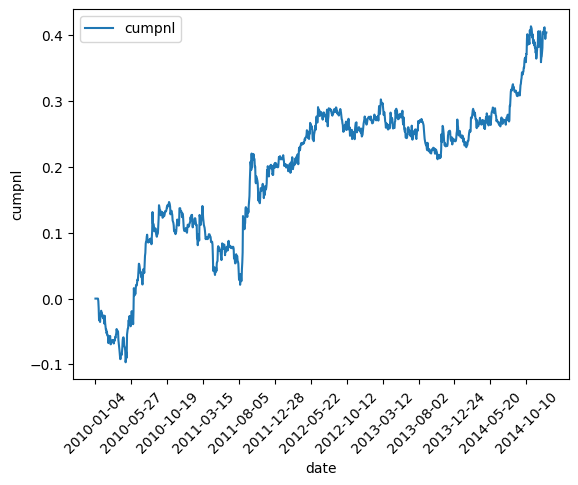

[0.10344481355579625, 0.2060959596678211, 0.2734583987148915, 0.23969840484729088, 0.4043370431567007]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.912552,0.774263,0.096753,0.103445
1,2011,0.742378,0.956714,0.119708,0.206096
2,2012,0.782612,0.838893,0.048731,0.273458
3,2013,-0.384917,0.795023,0.090916,0.239698
4,2014,1.584022,0.882743,0.054556,0.404337


In [32]:
alpha_2_data, alpha_2_cumpnl = AlphaStats(alpha_2, close_df)
alpha_2_data.head()

In [33]:
test3(alpha_2_data)

Sharpe test not passed
Turnover tets not passed
Cumpnl test passed
passed 1 out of 3 tests


In [182]:
check_alpha_correlations(alphas, alpha_2_cumpnl)

mean_reverse:	0.9281811977109417


# Alpha 3

**(-1 * correlation(rank(open), rank(volume), 10))**

In [35]:
def make_alpha_3(open_df, volume_df, day_step):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    _open = np.zeros_like(open)
    _volume = np.zeros_like(volume)

    for idx, (x, y) in enumerate(zip(open, volume)):
        _open[idx] = mpa.rank(x)
        _volume[idx] = mpa.rank(y)

    alpha = np.zeros((open.shape))

    for i in range(day_step, len(volume)):
        alpha[i] = -1 * ts_correlation(_open[i-day_step: i], _volume[i-day_step: i])

    return alpha

In [36]:
day_step = 10

alpha_3 = - make_alpha_3(open_df, volume_df, day_step)

alpha_3 = mpa.truncate_alpha(alpha_3, 3)

alpha_3 = neutralize(alpha_3)
alpha_3 = normalize(alpha_3)

test1(alpha_2)
test2(alpha_2[day_step:])

Neutrality test passed
Normality test passed


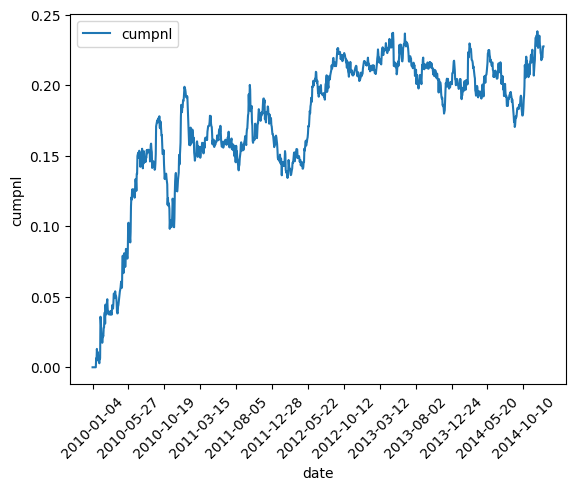

[0.1846421125702086, 0.1653821603838315, 0.20811160221461214, 0.20898418980174527, 0.22768136457576657]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,2.068841,0.504397,0.079860,0.184642
1,2011,-0.288869,0.444901,0.059282,0.165382
2,2012,0.880658,0.313134,0.031078,0.208112
3,2013,0.016810,0.261934,0.057286,0.208984
4,2014,0.291245,0.308782,0.059249,0.227681


In [37]:
alpha_3_data, alpha_3_cumpnl = AlphaStats(alpha_3, close_df)
alpha_3_data.head()

In [38]:
test3(alpha_3_data)

Sharpe test not passed
Turnover test passed
Cumpnl test not passed
passed 1 out of 3 tests


In [183]:
check_alpha_correlations(alphas, alpha_3_cumpnl)

mean_reverse:	0.8251556642631087


## Alpha 4

**(-1 * Ts_Rank(rank(low), 9))**

In [40]:
def ts_rank(time_series):
    result = np.zeros(time_series.shape[1])

    for i in range(len(result)):
        result[i] = mpa.rank(time_series.T[i])[-1]

    return result

In [41]:
def make_alpha_4(low_df, day_step):
    low = low_df.drop(low_df.columns[0], axis=1).to_numpy().T

    low_ranked = np.zeros((low.shape))
    for idx, _low in enumerate(low):
        low_ranked[idx] = mpa.rank(_low)

    alpha = np.zeros_like(low)
    for i in range(day_step, len(low_ranked)):
        alpha[i] = -1 * ts_rank(low_ranked[i-9:i])
        
    # return np.concatenate((np.zeros((day_step, low_ranked.shape[1])), low_ranked[day_step:]))
    return alpha

In [42]:
day_step = 9

alpha_4 = make_alpha_4(low_df, day_step)

alpha_4 = neutralize(alpha_4)
alpha_4 = normalize(alpha_4)

In [43]:
test1(alpha_4)
test2(alpha_4[day_step:])

Neutrality test passed
Normality test passed


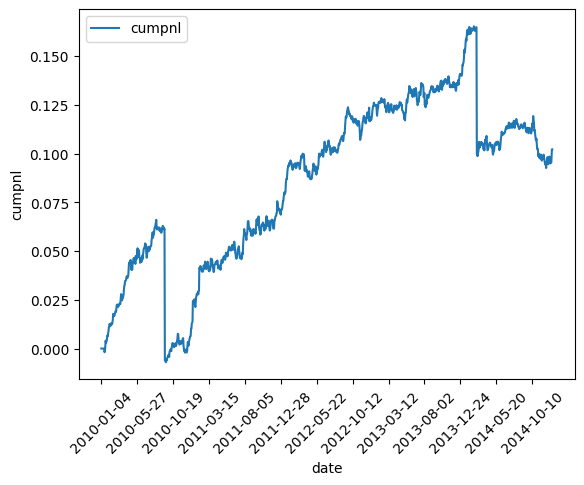

[0.010224528436257839, 0.07126043273881681, 0.11748531086598249, 0.14008944681948576, 0.10228143579833353]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.142697,0.216451,0.073131,0.010225
1,2011,2.083228,0.221668,0.009351,0.071260
2,2012,2.010727,0.222978,0.016769,0.117485
3,2013,0.952046,0.222495,0.012445,0.140089
4,2014,-0.544287,0.222388,0.072792,0.102281


In [44]:
alpha_4_data, alpha_4_cumpnl = AlphaStats(alpha_4, close_df)
alpha_4_data.head()

In [47]:
test3(alpha_4_data)

Sharpe test not passed
Turnover test passed
Cumpnl test not passed
passed 1 out of 3 tests


In [185]:
check_alpha_correlations(alphas, alpha_4_cumpnl)

mean_reverse:	0.8808486246457494


## Alpha 6

(-1 * correlation(open, volume, 10))

In [49]:
def make_alpha_6(open_df, volume_df, day_step):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    alpha = np.zeros((open.shape))

    for i in range(day_step, len(open)):
        alpha[i] = -1 * ts_correlation(open[i-day_step:i], volume[i-day_step:i])

    return alpha

In [50]:
day_step = 10

alpha_6 = make_alpha_6(open_df, volume_df, day_step)

alpha_6 = neutralize(alpha_6)
alpha_6 = normalize(alpha_6)

alpha_6.shape

(1257, 2436)

In [51]:
test1(alpha_6)
test2(alpha_6)

Neutrality test passed
Normality test is not passed


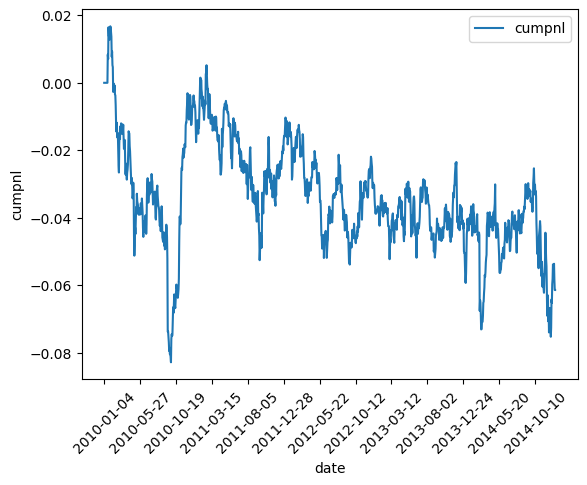

[-0.005393650259294827, -0.015776244220058903, -0.030270958681269822, -0.05037293629188285, -0.061358227341784664]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-0.099968,0.075045,0.099502,-0.005394
1,2011,-0.202965,0.063140,0.057725,-0.015776
2,2012,-0.363274,0.066375,0.043533,-0.030271
3,2013,-0.464552,0.059464,0.026906,-0.050373
4,2014,-0.202005,0.064519,0.049880,-0.061358


In [52]:
alpha_6_data, alpha_6_cumpnl = AlphaStats(alpha_6, close_df)
alpha_6_data.head()

In [53]:
test3(alpha_6_data)

Sharpe test not passed
Turnover test passed
Cumpnl test not passed
passed 1 out of 3 tests


In [186]:
check_alpha_correlations(alphas, alpha_6_cumpnl)

mean_reverse:	-0.5113485326688711


## Alpha 7

((adv20 < volume) ? ((-1 * ts_rank(abs(delta(close, 7)), 60)) * sign(delta(close, 7))) : (-1 * 1))

In [57]:
def average_dayly_volume(volume, day_step):
    adv = np.zeros_like(volume)

    for i in range(day_step, len(volume)):
        adv[i] = volume[i].mean()

    return adv

In [60]:
def make_alpha_7(volume_df, close_df):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    
    adv = average_dayly_volume(volume, 20)

    close_delta = np.concatenate((np.zeros((7, close.shape[1])), close[7:] - close[:-7]))

    alpha = np.zeros_like(volume)
    for i in range(60, len(alpha)):
        alpha[i] = np.where(adv[i] < volume[i], -1 * ts_rank(np.abs(close_delta[i-60:i])) * np.sign(close_delta)[i], -1)      
                    

    return alpha
        

In [61]:
alpha_7 = make_alpha_7(volume_df, close_df)

In [62]:
_alpha_7 = neutralize(alpha_7)
_alpha_7 = normalize(_alpha_7)

test1(_alpha_7)
test2(_alpha_7[60:])

Neutrality test passed
Normality test passed


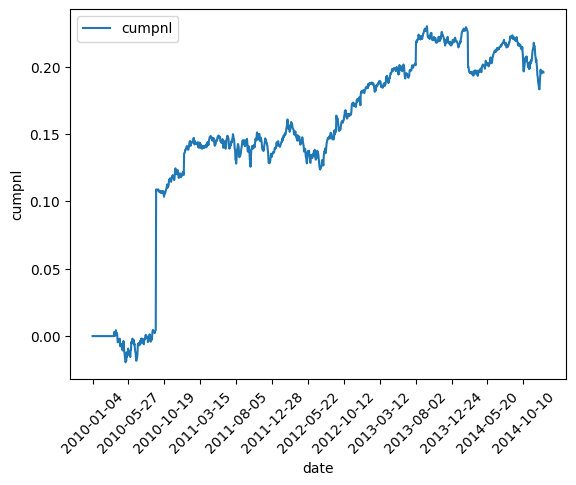

[0.12074822217289795, 0.13552356496091159, 0.18190225007888136, 0.21980044893112893, 0.19573339296353862]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,1.118241,0.167245,0.023804,0.120748
1,2011,0.404623,0.214828,0.024225,0.135524
2,2012,1.413016,0.220072,0.037167,0.181902
3,2013,1.310842,0.236678,0.014310,0.219800
4,2014,-0.638623,0.234801,0.046137,0.195733


In [63]:
alpha_7_data, alpha_7_cumpnl = AlphaStats(_alpha_7, close_df)
alpha_7_data.head()

In [64]:
test3(alpha_7_data)

Sharpe test passed
Turnover test passed
Cumpnl test not passed
passed 2 out of 3 tests


In [188]:
check_alpha_correlations(alphas, alpha_7_cumpnl)

mean_reverse:	0.8734274690304221


## Alpha 8

**(-1 * rank(((sum(open, 5) * sum(returns, 5)) - delay((sum(open, 5) * sum(returns, 5)), 10))))**

In [74]:
def make_alpha_8(open_df, close_df, sum_window=5, delay_window=10):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T
    
    return_matrix = instrument_return(close_df)

    open_sums = np.zeros(open.shape)
    returns_sums = np.zeros_like(return_matrix)
    for i in range(sum_window, len(open_sums)):
        open_sums[i] = open[i-sum_window:i].sum(axis=0)
        returns_sums[i] = return_matrix[i-sum_window:i].sum(axis=0)

    multy = returns_sums * open_sums

    alpha = np.zeros(open.shape)
    for i in range(delay_window, len(alpha)):
        alpha[i] = -1 * mpa.rank(multy[i] - multy[i-delay_window])

    return alpha

In [78]:
sum_step = 5
delay_step = 10

alpha_8 = make_alpha_8(open_df, close_df, sum_step, delay_step)

alpha_8 = neutralize(alpha_8)
alpha_8 = normalize(alpha_8)

test1(alpha_8)
test2(alpha_8[delay_step:])

Neutrality test passed
Normality test passed


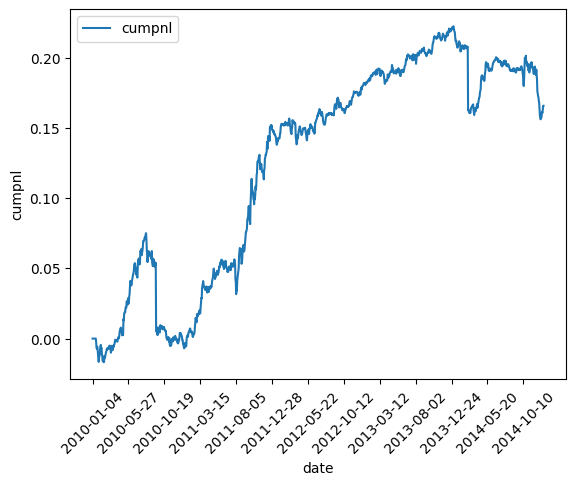

[-0.001134098145561627, 0.14870961281898507, 0.17978223421853148, 0.2211693315644873, 0.1659037122508854]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-0.018430,0.546528,0.080410,-0.001134
1,2011,3.118799,0.556526,0.024734,0.148710
2,2012,1.192493,0.551849,0.018421,0.179782
3,2013,1.940114,0.547307,0.010862,0.221169
4,2014,-1.005385,0.530429,0.066277,0.165904


In [79]:
alpha_8_data, alpha_8_cumpnl = AlphaStats(alpha_8, close_df)
alpha_8_data.head()

In [80]:
test3(alpha_8_data)

Sharpe test passed
Turnover test passed
Cumpnl test not passed
passed 2 out of 3 tests


In [189]:
check_alpha_correlations(alphas, alpha_8_cumpnl)

mean_reverse:	0.9512684386663794


## Alpha 9

**((0 < ts_min(delta(close, 1), 5)) ? delta(close, 1) : ((ts_max(delta(close, 1), 5) < 0) ? delta(close, 1) : (-1 * delta(close, 1))))**

In [90]:
def ts_min(matrix):
    return np.min(matrix, axis=0)

In [92]:
def ts_max(matrix):
    return np.max(matrix, axis=0)

In [143]:
def make_alpha_9(close_df, min_max_window=10, delta_window=1):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    _close = np.concatenate((np.zeros((1, close.shape[1])), close[delta_window:] - close[:-delta_window]))

    alpha = np.zeros_like(close)
    for i in range(min_max_window+1, len(alpha)):
        alpha[i] = np.where(ts_min(_close[i-1-min_max_window: i-1]) > 0, 
                            _close[i-1], 
                            np.where(ts_max(_close[i-1-min_max_window:i-1]) < 0, _close[i-1], -1 * close[i-1]))

    return alpha

In [144]:
min_max_window = 10
delta_window = 1

alpha_9 = make_alpha_9(close_df, min_max_window, delta_window)

alpha_9 = neutralize(alpha_9)
alpha_9 = normalize(alpha_9)

test1(alpha_9)
test2(alpha_9[min_max_window:])

Neutrality test passed
Normality test is not passed


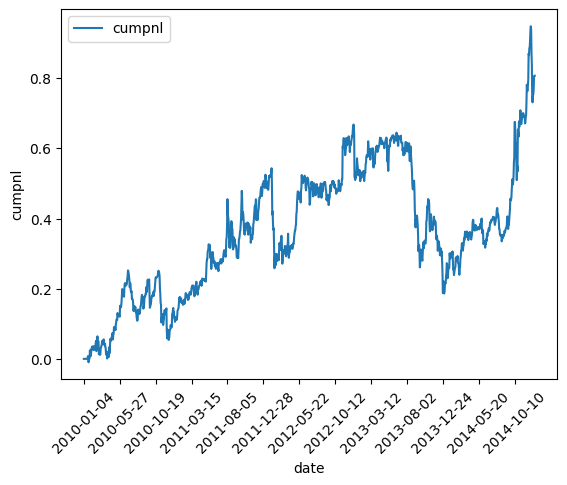

[0.133337461643025, 0.5072235662601874, 0.6678753345766038, 0.18655818776466587, 0.8077204343727433]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.654483,0.004030,0.198295,0.133337
1,2011,1.497462,0.000116,0.168209,0.507224
2,2012,0.590906,0.018125,0.285168,0.667875
3,2013,-1.607344,0.000216,0.481317,0.186558
4,2014,1.968197,0.000359,0.216875,0.807720


In [145]:
alpha_9_data, alpha_9_cumpnl = AlphaStats(alpha_9, close_df)
alpha_9_data.head()

In [146]:
test3(alpha_9_data)

Sharpe test not passed
Turnover test passed
Cumpnl test passed
passed 2 out of 3 tests


In [190]:
check_alpha_correlations(alphas, alpha_9_cumpnl)

mean_reverse:	0.7753719932513845


## Alpha 10

**rank(((0 < ts_min(delta(close, 1), 4)) ? delta(close, 1) : ((ts_max(delta(close, 1), 4) < 0) ? delta(close, 1) : (-1 * delta(close, 1)))))**

In [148]:
def make_alpha_10(close_df, min_max_window=4, delta_window=1):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T

    _close = np.concatenate((np.zeros((1, close.shape[1])), close[delta_window:] - close[:-delta_window]))

    sub_alpha = np.zeros_like(close)

    for i in range(min_max_window+1, len(sub_alpha)):
        sub_alpha[i] = mpa.rank(np.where(ts_min(_close[i-1-min_max_window:i-1]) > 0, 
                                _close[i-1], 
                                np.where(ts_max(_close[i-1-min_max_window: i-1])<0, _close[i-1], -1 * _close[i-1])))

    return sub_alpha

In [149]:
min_max_window = 4
delta_window = 1

alpha_10 = make_alpha_10(close_df, min_max_window, delta_window)

alpha_10 = neutralize(alpha_10)
alpha_10 = normalize(alpha_10)

test1(alpha_10)
test2(alpha_10[min_max_window:])

Neutrality test passed
Normality test is not passed


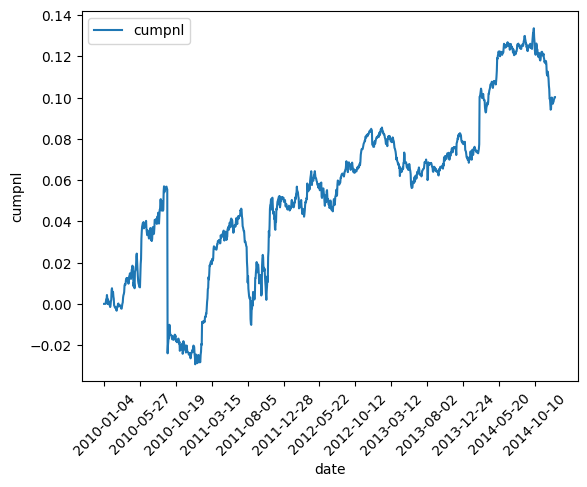

[-0.0208093925487973, 0.04945468706522463, 0.0761393688211244, 0.077395879489923, 0.10023871267312093]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-0.239922,1.235631,0.083396,-0.020809
1,2011,1.523260,1.264663,0.056368,0.049455
2,2012,0.990410,1.254243,0.019473,0.076139
3,2013,0.053618,1.257487,0.029340,0.077396
4,2014,0.692617,1.255143,0.039483,0.100239


In [150]:
alpha_10_data, alpha_10_cumpnl = AlphaStats(alpha_10, close_df)
alpha_10_data.head()

In [151]:
test3(alpha_10_data)

Sharpe test not passed
Turnover tets not passed
Cumpnl test not passed
passed 0 out of 3 tests


In [191]:
check_alpha_correlations(alphas, alpha_10_cumpnl)

mean_reverse:	0.8924883759154326


## Alpha 11

**((rank(ts_max((vwap - close), 3)) + rank(ts_min((vwap - close), 3))) * rank(delta(volume, 3)))**

## Alpha 12

**(sign(delta(volume, 1)) * (-1 * delta(close, 1)))**

In [162]:
def make_alpha_12(volume_df, close_df, delta_window):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T

    alpha = np.zeros_like(close)
    for i in range(delta_window+1, len(alpha)):
        alpha[i] = np.sign(volume[i-1] - volume[i-1-delta_window]) * (-1 * close[i-1] - close[i-1-delta_window])

    return alpha

In [173]:
delta_window  = 1

alpha_12 = make_alpha_12(volume_df, close_df, delta_window)

alpha_12 = neutralize(alpha_12)
alpha_12 = normalize(alpha_12)

test1(alpha_12)
test2(alpha_12[delta_window+1:])

Neutrality test passed
Normality test passed


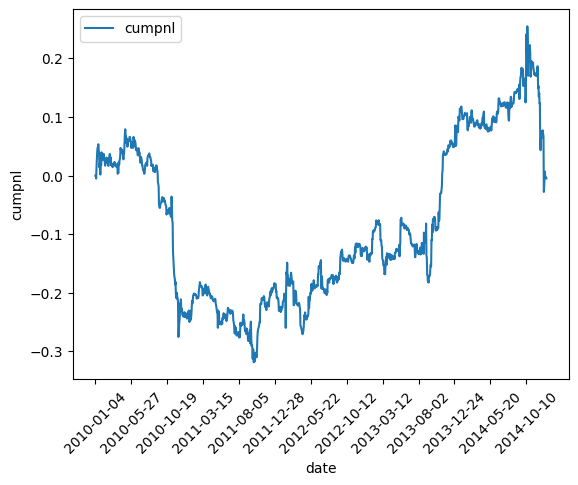

[-0.23550746911962475, -0.1848761918897723, -0.12340140011896913, 0.0506751545031163, -0.004798117080786417]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-1.596816,1.453379,0.354394,-0.235507
1,2011,0.427901,1.527351,0.136718,-0.184876
2,2012,0.406819,1.445123,0.122096,-0.123401
3,2013,1.070339,1.445802,0.110589,0.050675
4,2014,-0.239634,1.519845,0.282654,-0.004798


In [176]:
alpha_12_data, alpha_12_cumpnl = AlphaStats(alpha_12, close_df)
alpha_12_data.head()

In [165]:
test3(alpha_12_data)

Sharpe test not passed
Turnover tets not passed
Cumpnl test not passed
passed 0 out of 3 tests


In [192]:
check_alpha_correlations(alphas, alpha_12_cumpnl)

mean_reverse:	0.2917036768845179


## Alpha 13

**(-1 * rank(covariance(rank(close), rank(volume), 5)))**

In [167]:
def covarience(vector1, vector2):
    return np.sum((vector1 - vector1.mean()) * (vector2 - vector2.mean()), axis=0)

In [170]:
def make_alpha_13(close_df, volume_df, cov_window):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T

    alpha = np.zeros_like(close)

    close_ranked = np.array([mpa.rank(_close) for _close in close])
    volume_ranked = np.array([mpa.rank(_volume) for _volume in volume])

    for i in range(cov_window+1, len(close)):
        alpha[i] = -1 * mpa.rank(covarience(close_ranked[i-1-cov_window:i-1], volume_ranked[i-1-cov_window:i-1]))

    return alpha

In [175]:
cov_window = 5

alpha_13 = make_alpha_13(close_df, volume_df, cov_window)

alpha_13 = neutralize(alpha_13)
alpha_13 = normalize(alpha_13)

test1(alpha_13)
test2(alpha_13[cov_window+1:])

Neutrality test passed
Normality test passed


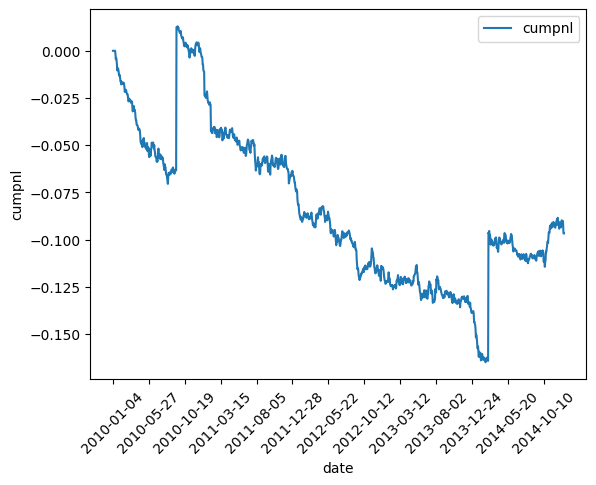

[-0.007380863190621352, -0.06603735151946581, -0.11461562460332769, -0.13782712733352953, -0.09668241040542913]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-0.092926,0.013104,0.070505,-0.007381
1,2011,-1.852965,0.009552,0.062824,-0.066037
2,2012,-2.054331,0.008214,0.055735,-0.114616
3,2013,-0.956508,0.007494,0.025274,-0.137827
4,2014,0.568469,0.007631,0.027067,-0.096682


In [177]:
alpha_13_data, alpha_13_cumpnl = AlphaStats(alpha_13, close_df)
alpha_13_data.head()

In [178]:
test3(alpha_13_data)

Sharpe test not passed
Turnover test passed
Cumpnl test not passed
passed 1 out of 3 tests


In [193]:
check_alpha_correlations(alphas, alpha_13_cumpnl)

mean_reverse:	-0.8546658065209484


## Alpha 14

**((-1 * rank(delta(returns, 3))) * correlation(open, volume, 10))**

In [195]:
def make_alpha_14(close_df, open_df, volume_df, delta_window=3, cor_window=10):
    close = close_df.drop(close_df.columns[0], axis=1).to_numpy().T
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    open = open_df.drop(open_df.columns[0], axis=1).to_numpy().T

    returns = instrument_return(close_df)

    alpha = np.zeros_like(close)
    for i in range(cor_window+1, len(alpha)):
        alpha[i] = -1 * mpa.rank(returns[i-1] - returns[i-1-delta_window]) * calc_alphas_corr(open[i-1-cor_window:i-1], 
                                                                                              volume[i-1-cor_window:i-1])

    return alpha

In [201]:
delta_window = 3
cor_window = 10

alpha_14 = make_alpha_14(close_df, open_df, volume_df, delta_window, cor_window)

alpha_14 = neutralize(alpha_14)
alpha_14 = normalize(alpha_14)

test1(alpha_14)
test2(alpha_14[cor_window+1:])

Neutrality test passed
Normality test passed


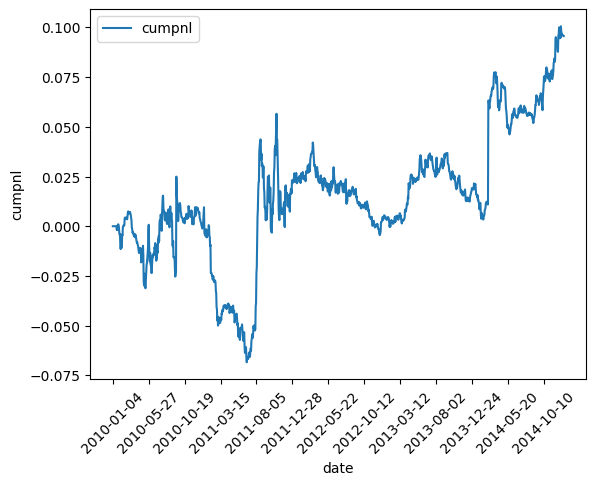

[-0.0008096765317783471, 0.021918364513649265, 0.004489141598519368, 0.01864675783601726, 0.09562502675293076]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,-0.011947,1.245814,0.040714,-0.000810
1,2011,0.306565,1.304727,0.077988,0.021918
2,2012,-0.535587,1.286928,0.046506,0.004489
3,2013,0.530353,1.296258,0.024414,0.018647
4,2014,1.242091,1.299035,0.031311,0.095625


In [202]:
alpha_14_data, alpha_14_cumpnl = AlphaStats(alpha_14, close_df)
alpha_14_data.head()

In [203]:
test3(alpha_14_data)

Sharpe test not passed
Turnover tets not passed
Cumpnl test not passed
passed 0 out of 3 tests


In [204]:
check_alpha_correlations(alphas, alpha_14_cumpnl)

mean_reverse:	0.6936446199446732


## Alpha 15

**-1 * sum(rank(correlation(rank(high), rank(volume), 3)), 3)**

In [214]:
def make_alpha_15(high_df, volume_df, cor_window=3, sum_window=3):
    volume = volume_df.drop(volume_df.columns[0], axis=1).to_numpy().T
    high = high_df.drop(high_df.columns[0], axis=1).to_numpy().T

    volume_ranked = np.array([mpa.rank(_volume) for _volume in volume])
    high_ranked = np.array([mpa.rank(_high) for _high in high])

    ranked_high_volume = np.zeros_like(volume)
    for i in range(cor_window, len(ranked_high_volume)):
        ranked_high_volume[i] = mpa.rank(ts_correlation(high_ranked[i-cor_window:i], volume_ranked[i-cor_window:i]))

    alpha = np.zeros_like(volume)
    for i in range(max(sum_window, cor_window)+1, len(alpha)):
        alpha[i] = -1 * np.sum(ranked_high_volume[i - sum_window-1:i-1], axis=0)

    return alpha

In [222]:
cor_window = 3
sum_window = 3

alpha_15 = make_alpha_15(high_df, volume_df, cor_window, sum_window)

alpha_15 = neutralize(alpha_15)
alpha_15 = normalize(alpha_15)

test1(alpha_15)
test2(alpha_15[max(cor_window, sum_window)+2:])

Neutrality test passed
Normality test passed


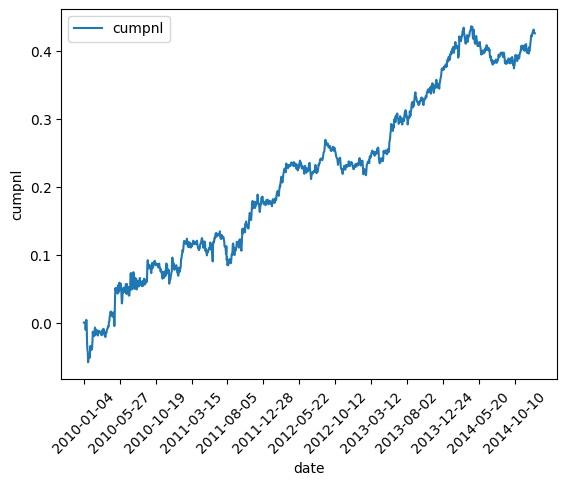

[0.08596026208747795, 0.17431013810514367, 0.2255269196547077, 0.3749800608876438, 0.42516647641281285]


,Year,Sharpe,Average Turnover,Max Drawdown,Cumpnl
0,2010,0.838514,0.186073,0.062374,0.085960
1,2011,1.113873,0.136954,0.049906,0.174310
2,2012,0.981899,0.145504,0.050166,0.225527
3,2013,2.314254,0.133759,0.025173,0.374980
4,2014,0.730279,0.123164,0.061981,0.425166


In [223]:
alpha_15_data, alpha_15_cumpnl = AlphaStats(alpha_15, close_df)
alpha_15_data.head()

In [224]:
test3(alpha_15_data)

Sharpe test not passed
Turnover test passed
Cumpnl test passed
passed 2 out of 3 tests


In [226]:
check_alpha_correlations(alphas, alpha_15_cumpnl)

mean_reverse:	0.9539031270926396


## Alpha 16

**(-1 * rank(covariance(rank(high), rank(volume), 5)))**